# 🌲 Análisis de Cicatrices de Incendios Forestales en la Patagonia con PyCUDA

> **Trabajo final del curso Introducción a la programación HPC con Python y sus aplicaciones al campo de proceso de imágenes 2025**  
> Autor: Mónica Denham  
> Fecha: septiembre/octubre 2025

***Resumen:***  Este notebook documenta el desarrollo de algoritmos para el cálculo de índices globalmente utilizados para trabajar áreas quemadas por incendios forestales con imágenes satelitales. En este trabajo, se aceleran los algoritmos propuestos usando PyCUDA. Se utilizan los índices **NVDI (Normalized Difference Vegetation Index)** y **dNBR (Differenced Normalized Burn Ratio)** aplicado a imágenes Landsat 8 de la zona de los lagos Steffen y Martín (Patagonia Argentina), afectada por incendios entre diciembre 2021 y marzo 2022.

***Aclaración:*** Es sabido que para realizar análisis de rendimiento se busca realizar las pruebas con grandes requerimientos de cómputo y/o grandes volúmenes de datos. En este caso, al trabajar con imágenes satelitales y al dificultarse más que nada en todo este trabajo la obtención de imágenes que resulten interesantes de ver los resultados, este informe trabajará con un área de interés (AOI) no muy grande y con un solo AOI que arroja resultados útiles para la propuesta. Luego, a fin de aumentar el requerimiento de cómputo, se iterará el procesamiento sobre las mismas imágenes satelitales múltiples veces (con la constante `ITERACIONES`). 


---


### 🎯 Objetivos

- Presentar el contexto del incendio utilizando como caso de estudio. 
- Resumir datos a utilizar, imágenes satelitales, bandas espectrales, AOI. 
- Presentar los índices **NVIDI** y **dNBR**, sus características, principales usos e interpretación de dichos índices. 
- Implementar secuencialmente el cálculo del índice **NDVI** para el análisis de estado de vegetación.
- Implementar secuencialmente el cálculo del índice **dNBR** para detección de áreas quemadas.
- Acelerar el procesamiento mediante **PyCUDA** (GPU) del **NDVI** y del **dNBR**.
- Comparar tiempos de ejecución CPU vs GPU. Realizar el análisis de rendimiento de las aplicaciones. 
- Arribar a conclusiones considerando los aspectos vistos durante el curso. Previo a las conclusiones finales, se puntearán obstáculos y algunas soluciones encontradas. 
- Documentar el proceso de forma clara, reproducible e interactiva.


---


### 🌍 Contexto: Incendio Forestal en las inmediaciones de los lagos Steffen y Martin ubicados en la Patagonia Argentina en la temporada de incendio 2021-2022. 

#### 📍 Área de estudio

- **Ubicación**: Zona de los lagos Steffen y Martin, Patagonia Argentina (centro en `-41.515440, -71.635491`). Ver Figura 1. 
- **Coordenadas del AOI**: minx: -71.7508, miny: -41.5833, maxx: -71.4095, maxy: -41.4419

#### 🔥 Datos del incendio

- **Fechas**: Diciembre 2021 a Marzo 2022.
- **Superficie afectada estimada**: un poco más de 6000 hectáreas.
- **Fuente de datos satelitales**: Landsat 8 Collection 2 Level 2 (Surface Reflectance) — Planetary Computer [2]. Se desacargaron todas las bandas de las imágenes pero se va a trabajar con un subconjunto de las mismas, las cuales se presentarán más adelante. 
- **Fuente de información del incendio**: *Técnicas para el abordaje de la evaluación y predicción del comportamiento del fuego: experiencia del equipo conformado para el incendio Steffen-Martin*. Parque Nacional Nahuel Huapi, diciembre 2021 - marzo 2022. [5].
  
<img src="images/01_mapa_Steffen_Martin.png" width="800" />[5]


Con el fin de conocer más el caso de estudio se copia una imagen publicada en [5]: en la figura se observa el avance del incendio ajustada a distintas técnicas: observación a campo mediante fotografía y tracks, ajustes con imágenes satelitales y focos de calor. Observar las zonas correspondiente a los Lagos Steffen y Martin, a fin de detectarlos en las figuras que se presentarán durante este informe y mejorar la interpretación de los índices calculados. 

<img src="images/02_diagrama_avance_Steffen_Martin.png" width="800" />[5]



---


### 📐 Cálculos de índices relacionados a incendios forestales: NDVI y dNBR. 

Se aboradarán los cálculos del NVDI y del dNBR, ambos índices globalmente utilizados en el contexto de incendios forestales. A continuación se presenta cada uno de estos índices. Más adelante, al presentar las imágenes resultantes se incluirá el modo en que estos índices se interpretan en el contexto de los incendios forestales.  

#### ✔️ NDVI: Normalized Difference Vegetation Index (Índice Normalizado de Diferencia Vegetal)

Es un índice espectral ampliamente utilizado en teledetección para evaluar la presencia, salud y densidad de vegetación en una superficie.

El índice NVDI se calcula como:

$$
\text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}}
$$

Donde:
- **NIR** = Reflectancia en el infrarrojo cercano (Banda 5 de Landsat 8).
- **RED** = Reflectancia en el rojo visible (Banda 4 de Landsat 8).


Rango de valores

- 1 a 0: Agua, nubes, nieve, roca desnuda.
- 0 a 0.2: Suelo desnudo, áreas urbanas, vegetación muy escasa.
- 0.2 a 0.5: Vegetación moderada (pastizales, cultivos).
- 0.5 a 0.9: Vegetación densa y saludable (bosques, selvas).

> Valores > 0.9 suelen indicar errores o condiciones atípicas. 

En este trabajo relacionado a incendios forestales, en NDVI es útil para:

- Validar que tu AOI tiene vegetación antes del incendio (NDVI > 0.3).
- Confirmar pérdida de vegetación post-incendio (NDVI disminuye).
- Complementar el análisis con dNBR, que es más específico para quemados.


####  ✔️  NBR (Normalized Burn Ratio)

El NBR es usado para identificar áreas quemadas y provee una medida de severidad de incendio. 

El índice NBR se calcula como [1]:

$$
\text{NBR} = \frac{\text{NIR} - \text{SWIR2}}{\text{NIR} + \text{SWIR2}}
$$

Donde:
- **NIR** = Reflectancia en el infrarrojo cercano (Banda 5 de Landsat 8).
- **SWIR2** = Reflectancia en el infrarrojo de onda corta 2 (Banda 7 de Landsat 8).
  
> 📌 **Nota**: Para evitar división por cero, en la implementación se agrega un épsilon pequeño:  
 `NBR = (NIR - SWIR2) / (NIR + SWIR2 + 1e-8)`

 > **Nota técnica**: En Microsoft Planetary Computer, las bandas de Landsat 8 Collection 2 Level 2 se exponen con nombres como `nir08` (Banda 5) y `swir22` (Banda 7). Aunque los nombres son distintos, corresponden exactamente a las bandas espectrales requeridas para el cálculo del NBR.


 ####  ✔️ dNBR (Differenced Normalized Burn Ratio)

 En dNBR es la diferencia entre el NBR post y pre incendio: mide cambio debido a incendio (requiere imágenes pre y post)

**Fórmula**:  
$$
\text{dNBR} = \text{NBR}_{\text{pre}} - \text{NBR}_{\text{post}}
$$  



---

## Códigos Secuenciales y paralelos (PyCUDA) para realizar el procesamiento

In [2]:
# %% [code]
# --- Cálculo de NBR en GPU con PyCUDA ---
# NOTA PARA EVALUADORES: Este código requiere GPU NVIDIA + CUDA.
# Los resultados que ven abajo fueron generados en mi máquina local.
# Pueden ver los tiempos y gráficos sin necesidad de ejecutar.

### Importar las librerías necesarias para: PyCUDA, procesamiento de imágenes geoespaciales, cronómetros, etc. 

❌ Al intentar usar `cv2` como se mostró en algunos ejemplos del curso, no se pudo usar la función imread() de dicha librería porque los tiff descargados son de 32bits. 

✅ Entonces, se usa la librería `rasterio` que está desarrollada para datos científicos y geoespaciales [4]. 


In [3]:
# %% [code]
import numpy as np
import time
import rasterio
import pycuda.driver as drv
import matplotlib.pyplot as plt

# constante que se usa para aumentar el cómputo
# al iterar el procesamiento varias veces
ITERACIONES = 10

print("✅ Librerías importadas 🔥.")

✅ Librerías importadas 🔥.


### Carga de bandas para calcular el NDVI y el dNBR

In [4]:
# Funcion para cargar una banda de un archivo raster usando rasterio
def cargar_banda(ruta):
    with rasterio.open(ruta) as src:
        return src.read(1).astype('float32')  # Lee la primera banda como float32

# Se cargan las bandas NIR, SWIR2  y RED del pre incendio y post incendio
# estas son las bandas necesarias para calcular el NDVI y el dNBR 
nir_pre = cargar_banda("data/pre_fire_2021_SR_B5.tif")
swir2_pre = cargar_banda("data/pre_fire_2021_SR_B7.tif")
nir_post = cargar_banda("data/post_fire_2022_SR_B5.tif")
swir2_post = cargar_banda("data/post_fire_2022_SR_B7.tif")
red_pre = cargar_banda("data/pre_fire_2021_SR_B4.tif")
red_post = cargar_banda("data/post_fire_2022_SR_B4.tif")

print("✅ Bandas cargadas.")
print(f"✅ Shape imágenes: {nir_pre.shape} 📐")
    

✅ Bandas cargadas.
✅ Shape imágenes: (552, 965) 📐


In [5]:
# Verificación de valores máximos y mínimos de las bandas cargadas. Esto se hace ya que hubo problemas con escaleo de las imágenes previamente. 
print("✅ NIR pre min/max:", nir_pre.min(), nir_pre.max(), "NIR post min/max: ", nir_post.min(), nir_post.max())
print("✅ SWIR2 pre min/max:", swir2_pre.min(), swir2_pre.max(), "SWIR2 post min/max:", swir2_post.min(), swir2_post.max())
print("✅ RED pre min/max:", red_pre.min(), red_pre.max(), "RED post min/max:", red_post.min(), red_post.max(),)

✅ NIR pre min/max: -0.083235 1.0638175 NIR post min/max:  -0.2 1.599985
✅ SWIR2 pre min/max: -0.004777506 0.36782002 SWIR2 post min/max: -0.01839 0.652555
✅ RED pre min/max: -0.1562475 1.2153975 RED post min/max: -0.2 1.599985


### Cálculo secuencial del NDVI pre y post incendio y toma de tiempos. Visualización del resultado

#### Función auxiliar para imprimir las imágenes 

In [6]:
# función auxiliar para visualizar imágenes
def mostrar_imagenes_pre_y_post(imagen_pre, imagen_post, titulo_pre, titulo_post, cmap='gray', vmin=None, vmax=None):
    # se arma una figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # imagen pre-incendio
    im1 = ax1.imshow(imagen_pre, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
    ax1.set_title(titulo_pre, fontsize=14)
    ax1.set_xlabel('Columnas')
    ax1.set_ylabel('Filas')
    plt.colorbar(im1, ax=ax1, shrink=0.8)

    # imagen post-incendio
    im2 = ax2.imshow(imagen_post, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
    ax2.set_title(titulo_post, fontsize=14)
    ax2.set_xlabel('Columnas')
    ax2.set_ylabel('Filas')
    plt.colorbar(im2, ax=ax2, shrink=0.8)

    plt.tight_layout()
    #plt.savefig('results/ndvi_comparacion.png', dpi=150, bbox_inches='tight')
    plt.show()

#### Cálculo secuencial del NVDI pre y post incendio

✅ Cálculo secuencial del NDVI pre incendio finalizado.
✅ Cálculo secuencial del NDVI post incendio finalizado.
✅ Cálculo secuencial del NDVI finalizado en 9.4029 segundos.


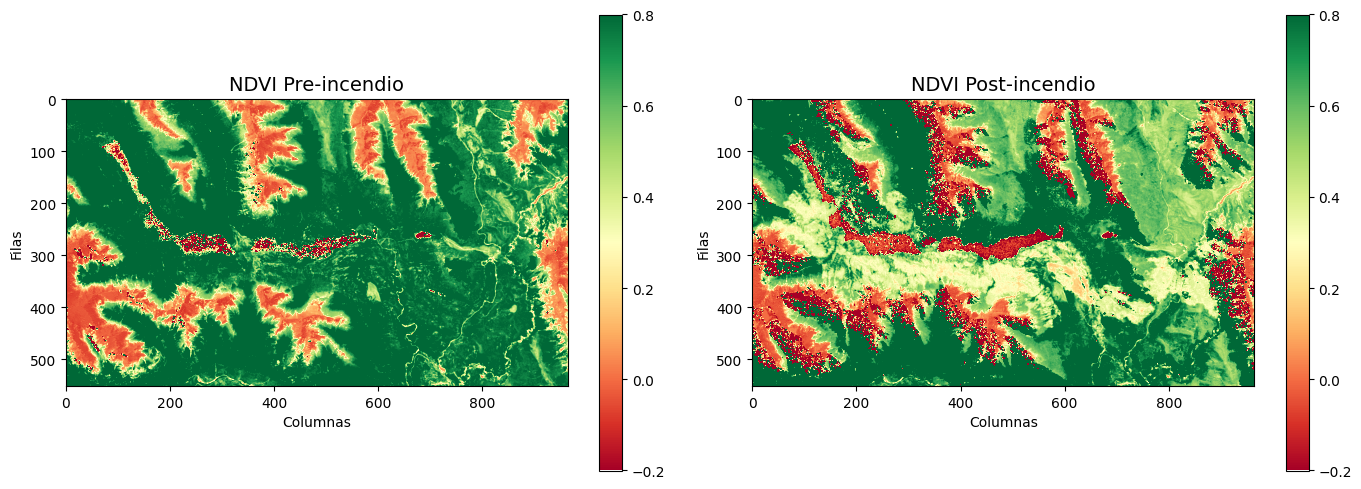

In [7]:
# Se calcula el NDVI pre y post incendio en CPU
# el cálculo es NBR = (NIR - SWIR2) / (NIR + SWIR2 + 1e-8)
filas = nir_pre.shape[0]
cols = nir_pre.shape[1]
ndvi_pre = np.zeros((filas, cols), dtype=np.float32)
ndvi_post = np.zeros((filas, cols), dtype=np.float32)

# cronometro inicio
sec_start = time.time()
for i in range(ITERACIONES):  # Aumento el cómputo iterando el procesamiento
    # loop principal
    for f in range(filas):
        for c in range(cols):
            # ndvi pre incendio
            ndvi_pre[f,c] = (nir_pre[f,c] - red_pre[f,c]) / (nir_pre[f,c] + red_pre[f,c] + 1e-8)
            # nbr post incendio
            ndvi_post[f,c] = (nir_post[f,c] - red_post[f,c]) / (nir_post[f,c] + red_post[f,c] + 1e-8)
#cronometro final
sec_end = time.time()

# resultados
print(f"✅ Cálculo secuencial del NDVI pre incendio finalizado.")
print(f"✅ Cálculo secuencial del NDVI post incendio finalizado.")
print(f"✅ Cálculo secuencial del NDVI finalizado en {sec_end - sec_start:.4f} segundos.")
mostrar_imagenes_pre_y_post(ndvi_pre, ndvi_post, 'NDVI Pre-incendio', 'NDVI Post-incendio', cmap='RdYlGn', vmin=-0.2, vmax=0.8)

# almaceno tiempos para análisis de rendimiento
cpu_ndvi_t = sec_end - sec_start


### Interpretación de NDVI 

Rangos de valores y significado:

🔺  -1 a 0: Agua, nubes, nieve, rocas desnudas. <br>
🔺  0 a 0.2: Suelo desnudo, áreas urbanas, vegetación escasa. <br>
🔺  0.2 a 0.5: Vegetación moderada (pastizales, cultivos).<br>
🔺  0.5 a 0.8: Vegetación densa (bosques, selvas).<br>
🔺  0.8: Raro; puede indicar errores o vegetación muy saludable.

En incendios:

> Pre-incendio: NDVI alto (0.4–0.8) en zonas boscosas.

> Post-incendio: NDVI disminuye drásticamente en áreas quemadas.

**Se distingue claramente el incendio, la disminución drástica de los valores del NVDI en el área afectada.**

### Cálculo del dNBR (diferencia entre NBR pre y post incendio)


In [8]:
# Se calcula el NBR pre y post incendio en CPU
# el cálculo es NBR = (NIR - SWIR2) / (NIR + SWIR2 + 1e-8)
filas = nir_pre.shape[0]
cols = nir_pre.shape[1]
dnbr_sec = np.zeros((filas, cols), dtype=np.float32)

sec_start = time.time()
for i in range(ITERACIONES):  # Aumento el cómputo iterando el procesamiento
    for f in range(filas):
        for c in range(cols):
            # nbr pre incendio
            nbr_pre = (nir_pre[f,c] - swir2_pre[f,c]) / (nir_pre[f,c] + swir2_pre[f,c] + 1e-8)
            # nbr post incendio
            nbr_post = (nir_post[f,c] - swir2_post[f,c]) / (nir_post[f,c] + swir2_post[f,c] + 1e-8)

            d_nbr = nbr_pre - nbr_post
            # guardo el resultado en un raster de salida  
            dnbr_sec[f,c] = d_nbr
sec_end = time.time()

# resultados
print(f"✅ Cálculo secuencial del dNBR finalizado en {sec_end - sec_start:.4f} segundos.")

# almaceno tiempos para análisis de rendimiento
cpu_dnbr_t = sec_end - sec_start

✅ Cálculo secuencial del dNBR finalizado en 9.4657 segundos.


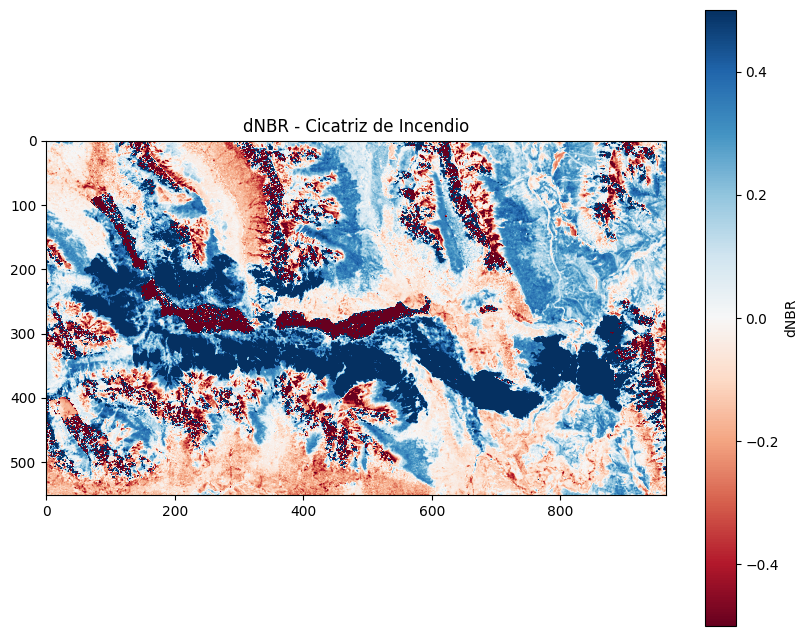

In [10]:
# visualizo resultados
plt.figure(figsize=(10, 8))
plt.imshow(dnbr_sec, cmap='RdBu', vmin=-0.5, vmax=0.5)
plt.colorbar(label='dNBR')
plt.title('dNBR - Cicatriz de Incendio')
plt.show()

#### Interpretación del dNBR

**Rango típico**: `[-1, 1]`  

**Interpretación (umbrales USGS)**:

| Clase                  | Rango dNBR     | Significado                     |
|------------------------|----------------|----------------------------------|
| Sin cambio             | < 0.1          | Sin quemado o cambios mínimos.  |
| Quemado levemente      | 0.1 – 0.27     | Pérdida leve de vegetación.     |
| Quemado moderadamente  | 0.27 – 0.44    | Pérdida moderada de vegetación. |
| Quemado severamente    | 0.44 – 0.66    | Pérdida severa de vegetación.   |
| Quemado muy severamente| > 0.66         | Suelo expuesto, cenizas.        |

**Clave**:  
- **dNBR > 0.2**: Indica quemado.  
- **dNBR < 0**: Raro; puede indicar regeneración post-incendio o errores.

Con estos procesamientos secuenciales corroboramos que el AOI es correcto, los procesamientos de los índices son correctos y obtenemos los tiempos secuenciales. A partir de la siguiente celda, se abordarán los algoritmos paralelos usando PyCUDA

## Cálculo de los índices NVDI y dNBR en paralelo usando PyCUDA en placas gráficas [3]

A fin de verificar la correctitud de los kernels, se vuelven a imprimir los resultados en imágenes, para asegurarnos que todo anduvo bien. 

### Carga de librerías para PyCUDA

In [11]:
# PARA USAR ACTIVAR EL ENTORNO
# source venv/bin/activate  (tengo la carpeta venv en el dir ../)

import numpy as np
import time
import rasterio
#from tqdm import tqdm
import os
import pycuda.driver as drv
import pycuda.autoinit
from   pycuda.compiler import SourceModule

### Reserva de memoria Global en device y transferencia de datos CPU -> GPU

In [12]:
# Reserva memoria en GPU, datos de entrada pre incendio
d_nir_pre = drv.mem_alloc(nir_pre.nbytes)
d_swir2_pre = drv.mem_alloc(swir2_pre.nbytes)
d_red_pre = drv.mem_alloc(red_pre.nbytes)
# Reserva memoria en GPU, datos de entrada post incendio
d_nir_post = drv.mem_alloc(nir_post.nbytes)
d_swir2_post = drv.mem_alloc(swir2_post.nbytes)
d_red_post = drv.mem_alloc(red_post.nbytes)

# Reserva de memoria en GPU para resultados
d_ndvi_pre = drv.mem_alloc(ndvi_pre.nbytes)
d_ndvi_post = drv.mem_alloc(ndvi_post.nbytes)
d_dnbr_final = drv.mem_alloc(dnbr_sec.nbytes)


# Transferencia de datos host->GPU de datos de entrada
drv.memcpy_htod(d_nir_pre, nir_pre)
drv.memcpy_htod(d_swir2_pre, swir2_pre)
drv.memcpy_htod(d_red_pre, red_pre)
drv.memcpy_htod(d_nir_post, nir_post)
drv.memcpy_htod(d_swir2_post, swir2_post)
drv.memcpy_htod(d_red_post, red_post)

print("✅ Memoria reservada en GPU.")
print("✅ Datos transferidos a GPU.")

✅ Memoria reservada en GPU.
✅ Datos transferidos a GPU.


### Armado de grilla y bloques de threads para ejecutar el kernel
Se elijen valores arbitrarios considerando bloques 2D de hasta 1024 threads y grilla 2D de bloques. Notar el cálculo de cantidad de bloques mínimo y suficiente para las figuras. 


In [13]:
# Armado de la grilla 2D con bloques 2D para mapear threads con imagen
bloque = (32, 32, 1)
grilla = ( (cols + bloque[0] - 1) // bloque[0], (filas + bloque[1] - 1) // bloque[1] )
print("📐 Dimensión de cada bloque (x,y,z): ", bloque)    
print("📐 Dimensión de la grilla: (x,y,z)", grilla)

# Declaracion de timers para GPU
start_evt = drv.Event()
end_evt = drv.Event()
print("✅ Clocks creados. 🕜")

📐 Dimensión de cada bloque (x,y,z):  (32, 32, 1)
📐 Dimensión de la grilla: (x,y,z) (31, 18)
✅ Clocks creados. 🕜


#### Definición del kernel paralelo para el cálculo del NVDI. Invocación al kernel y toma de tiempos

✅ Cálculo del NVDI previo al incendio en paralelo.
✅ Cálculo del NVDI posterior al incendio en paralelo.
✅ Paralelo. Tiempo cálculo:  0.004703044891357422 segundos.
✅ Paralelo. Tiempo cálculo usando eventos:  0.003912064090371132 segundos.


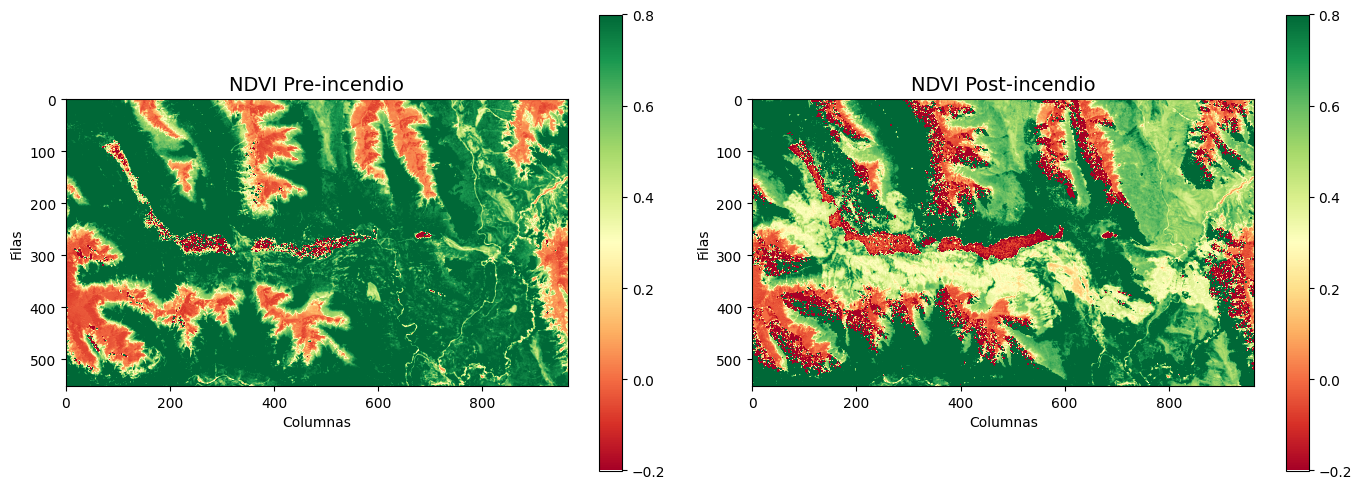

In [14]:
# Definición del kernel
mod = SourceModule ("""
__global__ void calcular_NDVI_paralelo(float *d_nir, float *d_red, float *d_ndvi, int filas, int cols) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int index = row * cols + col;
    
                        
    if (index < filas * cols) {
       d_ndvi[index] = (d_nir[index] - d_red[index]) / (d_nir[index] + d_red[index] + 1e-8);
     
    }
}
""")
elapsed_time_par = 0.0
# Ejecución del kernel y cronometraje. Se invoca al kernel dos veces, para calcular en NDVI pre y post incendio
par_start = time.time()
for i in range(ITERACIONES):  # Aumento el cómputo iterando el procesamiento
    start_evt.record()  # Inicio del timer GPU
    calcular_ndvi_paralelo = mod.get_function("calcular_NDVI_paralelo")
     # calculo del ndvi pre incendio
    calcular_ndvi_paralelo(d_nir_pre, d_red_pre, d_ndvi_pre, np.int32(filas), np.int32(cols), block=bloque, grid=grilla)
    # calculo del ndvi post incendio
    calcular_ndvi_paralelo(d_nir_post, d_red_post, d_ndvi_post, np.int32(filas), np.int32(cols), block=bloque, grid=grilla)
    end_evt.record()  # Fin del timer GPU
    end_evt.synchronize()  # Espera a que el evento de fin se complete  
    elapsed_time_par += start_evt.time_till(end_evt)  # Tiempo transcurrido en milisegundos    
par_end = time.time()

# Transferir datos GPU->host
ndvi_pre_par = np.empty_like(ndvi_pre)
ndvi_post_par = np.empty_like(ndvi_post)
drv.memcpy_dtoh(ndvi_pre_par, d_ndvi_pre)
drv.memcpy_dtoh(ndvi_post_par, d_ndvi_post )

# resultados
print("✅ Cálculo del NVDI previo al incendio en paralelo.")
print("✅ Cálculo del NVDI posterior al incendio en paralelo.")
print("✅ Paralelo. Tiempo cálculo: ", par_end - par_start, "segundos.")
print("✅ Paralelo. Tiempo cálculo usando eventos: ", elapsed_time_par *1e-3, "segundos.")

mostrar_imagenes_pre_y_post(ndvi_pre_par, ndvi_post_par, 'NDVI Pre-incendio', 'NDVI Post-incendio', cmap='RdYlGn', vmin=-0.2, vmax=0.8)

# almaceno tiempos para análisis de rendimiento
gpu_ndvi_t = par_end - par_start


### Definición del kernel CUDA para el cálculo del dNBR y lanzamiento del kernel 

In [16]:
# Definición del kernel
mod = SourceModule ("""
__global__ void calcular_dNBR_paralelo(float *d_nir_pre, float *d_swir2_pre, float *d_nir_post, float *d_swir2_post, float *d_dnbr_final, int filas, int cols) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int index = row * cols + col;
    float nbr_pre, nbr_post, d_nbr;
                        
    if (index < filas * cols) {
        nbr_pre = (d_nir_pre[index] - d_swir2_pre[index]) / (d_nir_pre[index] + d_swir2_pre[index] + 1e-8);
        nbr_post = (d_nir_post[index] - d_swir2_post[index]) / (d_nir_post[index] + d_swir2_post[index] + 1e-8);
        d_nbr = nbr_pre - nbr_post;                
        d_dnbr_final[index] = d_nbr;
    }
}
""")

# Ejecución del kernel y cronometraje
par_start = time.time()
for i in range(ITERACIONES):  # Aumento el cómputo iterando el procesamiento
    calcular_dnbr_paralelo = mod.get_function("calcular_dNBR_paralelo")
    calcular_dnbr_paralelo(d_nir_pre, d_swir2_pre, d_nir_post, d_swir2_post, d_dnbr_final, np.int32(filas), np.int32(cols), block=bloque, grid=grilla)

par_end = time.time()

# Transferir datos GPU->host
dnbr_final_par = np.empty_like(dnbr_sec)
drv.memcpy_dtoh(dnbr_final_par, d_dnbr_final)

# almaceno tiempos para análisis de rendimiento
gpu_dnbr_t = par_end - par_start
print("✅ Paralelo. Tiempo cálculo: ", par_end - par_start, "segundos.")

✅ Paralelo. Tiempo cálculo:  0.000431060791015625 segundos.


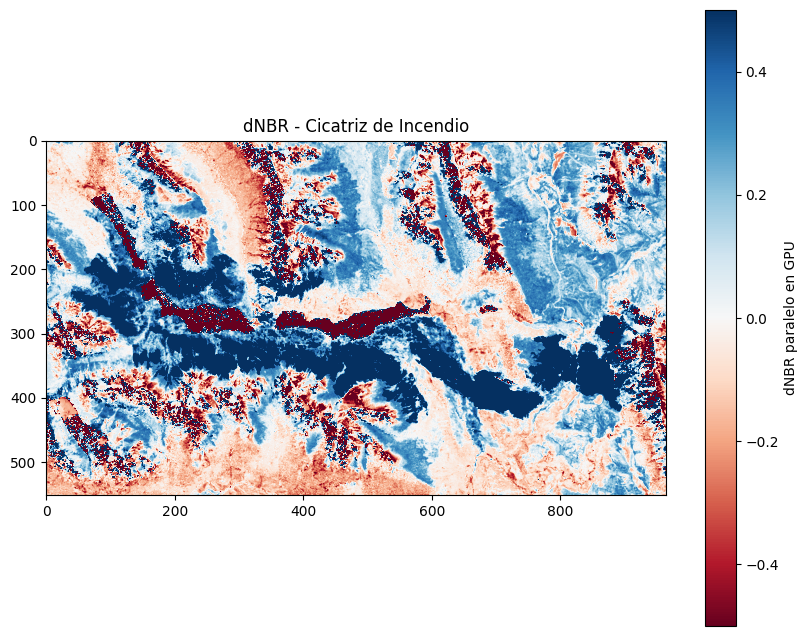

In [17]:
# visualizo resultados
plt.figure(figsize=(10, 8))
plt.imshow(dnbr_final_par, cmap='RdBu', vmin=-0.5, vmax=0.5)
plt.colorbar(label='dNBR paralelo en GPU')
plt.title('dNBR - Cicatriz de Incendio')
plt.show()

---

### 📊  Análisis de Rendimiento

En esta sección se analizarán métricas de rendimiento vistas durante el curso. 

a. SpeedUp: $$ S = \frac{T_s}{T_p}$$

Donde, 

- $T_s$: tiempo secuencial. 
- $T_p$: tiempo paralelo. 

In [18]:
# Calcular métricas
speedup_ndvi = cpu_ndvi_t / gpu_ndvi_t
speedup_dnbr = cpu_dnbr_t / gpu_dnbr_t

print(f"\n📊 RESULTADOS para", ITERACIONES, "iteraciones:")
print(f"NDVI - CPU: {cpu_ndvi_t:.4f}s | GPU: {gpu_ndvi_t:.4f}s | Speedup: {speedup_ndvi:.2f}x")
print(f"dNBR - CPU: {cpu_dnbr_t:.4f}s | GPU: {gpu_dnbr_t:.4f}s | Speedup: {speedup_dnbr:.2f}x")


📊 RESULTADOS para 10 iteraciones:
NDVI - CPU: 9.4029s | GPU: 0.0047s | Speedup: 1999.32x
dNBR - CPU: 9.4657s | GPU: 0.0004s | Speedup: 21959.03x


Se observa que el speedup aumenta notablemente en los algoritmos paralelos. La aceleración es muy notoria para ambos casos. 

A continuación se estudió la opción de usar el comando `nvprof` para el análisis de rendimiento de los kernels CUDA como así también las operaciones de transferencia de datos CPU ↔️ device. Como este comando no es posible ejecutarlo en este notebook jupiter, se ejecuta la misma aplicación por línea de comando y se copian los resultados a continuación. Como parte de este trabajo se entrega el script `calculos_incendios.py`, por lo que se debe ejecutar:
> nvprof python calculos_incendios.py

El resultado es: <br>

<img src="images/03_nvprof.png" width="800" />


Se puede observar que más del 65% del tiempo es de transferencia de datos entre la memoria RAM de la CPU y la memoria Global de la GPU. Este tipo de transferencia suele ser un punto clave para analizar en las aplicaciones. 

Luego, los kernels paralelo se llevan más del 32% del tiempo restante. Es notorio que el kernel del cálculo del NVDI se invoca 20 veces (en las 10 iteraciones) y el kernel del d_NBR se invoca 10. Sin embargo, el tiempo de ejecución de estos kernels no son "el doble" como se esperaría, ya que el cómputo dentro del los kernels es muy similar. Esto hace pensar que el uso de memorias (global? compartida?) dentro de cada SM y de cada bloque debe ser la responsable de este comportamiento. 

Para completar este trabajo se han estudiado métricas y eventos del comando `nvprof` (se pueden consultar con los comandos `nvprof --query-events` y `nvprof --query-metrics`). Pero no se han podido ejecutar por un tema de permisos seteados en el driver de la placa gráfica NVIDIA. 

También se han estudiado los events de CUDA: pycuda driver permite definir clocls (Events) y los mismos se usan como cronómetros antes y después de llamar a kernels y de sincronizar el trabajo en la GPU (para asegurarnos que todos los threads hayan finalizado). En el código se usan estos eventos, pero se pasó directamente a analizar la salida del comando `nvprof`. 

---

### 	⚠️  Obstáculos encontrados (y algunas soluciones)

A continuación se hará un punteo de los obstáculos encontrados y cómo se sortearon:

💥 La descarga de datos satelitales y su utilización en este trabajo 📡📡:<br>
- Se realizó un análisis de qué satélite usar y dentro del satélite qué data set utilizar. Por trabajos previos como así también por la bibliografía utilizada relacionada al caso de estudio, se decidió usar LandSat 8. <br>
- Las primeras imágenes descargadas con un AOI usado anteriormente no resultaron ser del área de interés, por lo que fueron descartados (el tiempo de descarga es considerable por estos lugares). <br>
- Se utilizó un script de JavaScript de Google Earth Engine que he usado para otro curso y con dicho script se armó uno en Python. Se imitó el AOI, filtro para nubes, rango de fechas, y se consiguió el AOI correcto e imágenes útiles para este trabajo. 

💥 Escalado de las bandas espectrales usadas: <br>
- En un momento los resultados eran todos los mínimos del rango posible. Esto era porque se había aplicado un escalado a las imágenes, sin saber que ya estaban escaladas 🔨. 

💥 Sintaxis propia de Python y PyCUDA que debo acostumbrarme. Por suerte está todo por demás documentado en internet. 

💥 Se planificó incluir métricas y eventos del comando `nvprof` para el análisis de rendimiento de la aplicación. No se pudieron incluir por permisos del driver de la placa gráfica. Dicho análisis iba a ser orientado al uso de memoria para intentar comprender de forma más precisa la ejecución de los kernels. 

💥 Los tiempos disponibles han hecho que se hayan desarrollado índices muy simples en su cálculo, pero que son un claro ejemplo de la posibilidad de realizar este tipo de cómputo para imágenes más grandes, para un gran número de imágenes y para cálculos más complejos. 



---

### 📢 Conclusiones

La realización de este curso y trabajo final me permitieron arribar a las siguientes conclusiones:

✔️ Python ofrece herramientas y estrategias para escribir aplicaciones paralelas y de alto rendimiento. Al tener conocimientos previos de C, pude observar semejanzas en: 
- Multiprocessing en Python equivalente a procesos en C (creados con fork()). 
- Multihilos en Python equivalente a threads (librería pthread) en C. 
- MPI en Python es como MPI en C. 

Lo que pude observar es que en Python se han desarrollado más abstracciones para multiprocesos, multihilos, etc. Es más "amigable" la programación en Python que en C, al menos para armar una aplicación paralela, para comunicar hijos o procesos, para sincronizarlos, etc. 

✔️ PyCUDA mezcla código secuencial en Python y kernels de CUDA, con la sintaxis CUDA. También se ofrecen abstracciones en tanto manejo de memorias, transferencia de datos y cómputo en las GPUs. 

✔️ En múltiples momentos del curso se mencionó que Python es un wrapper de C, y esto deriva en un lenguaje potente y con mayores abstracciones que C y más facil para programar. 

✔️ Me resulta interesante la posibilidad de generar aplicaciones rápidas en Python (secuenciales, paralelas). Dichas aplicaciones probarlas, entenderlas, testearlas y depurarlas. En cuanto la necesidad imperante sea la de aumentar el rendimiento, pasaría esa aplicación escrita en Python al lenguaje C y su extensión de CUDA ya que puede ser una oportunidad de aumentar su rendimiento. Esto si estamos trabajando a bajo nivel y donde sea de vital importancia el aumento en el rendimiento de la aplicación 🔍.   

---

## 📚 Referencias

1. USGS. *Landsat Normalized Burn Ratio (NBR)*.  
   https://www.usgs.gov/landsat-missions/landsat-normalized-burn-ratio  
   (Consultado: septiembre 2025)

2. Microsoft Planetary Computer. *Landsat Collection 2 Level 2 Surface Reflectance*.  
   https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2  
   (Consultado: septiembre 2025)

3. PyCUDA Documentation. *PyCUDA: Python wrapper for NVIDIA CUDA*.  
   https://documen.tician.de/pycuda/  
   (Consultado: septiembre 2025)

4. Rasterio Documentation. *Rasterio: geospatial raster I/O for Python*.  
   https://rasterio.readthedocs.io/  
   (Consultado: septiembre 2025)

5. Marcelo Bari, Paula Presti, Anabella Carp, Mariana Lipori. *Técnicas para el abordaje de la evaluación y predicción del comportamiento del fuego: experiencia del equipo conformado para el incendio Steffen-Martin. Parque Nacional Nahuel Huapi, diciembre 2021 - marzo 2022.* 
   (Consultado: septiembre 2025)